# notebooks/02_model_training.ipynb
# 1 - Prototypage des mod√®les de recommandation
## 1.1 - Imports & configuration
- Chargement des biblioth√®ques et configuration du notebook

In [1]:
import os
import sys
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from matplotlib import rcParams
import importlib
from dotenv import load_dotenv

In [2]:
# D√©termine dynamiquement le chemin racine du projet depuis le notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))  # remonte depuis notebooks/

# Chemin absolu vers le dossier src/
src_path = os.path.join(project_root, "src")

# Ajout au sys.path s'il n'y est pas d√©j√†
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(f"Projet racine : {project_root}")
print(f"Dossier src ajoute : {src_path}")

Projet racine : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python
Dossier src ajoute : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python\src


In [3]:
# CHARGEMENT OBLIGATOIRE des variables d'environnement
env_file = os.path.join(project_root, ".env.prod")
if os.path.exists(env_file):
    load_dotenv(env_file)
    print(f"Variables d'environnement chargees depuis : {env_file}")
    azure_conn = os.getenv("AZURE_CONN_STR")
    if azure_conn and "fresh2025" in azure_conn:
        print("Configuration Azure a jour (fresh2025)")
    else:
        print("ATTENTION: Configuration Azure obsolete ou manquante")
else:
    print(f"ERREUR: fichier .env.prod non trouve : {env_file}")

Variables d'environnement chargees depuis : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python\.env.prod
Configuration Azure a jour (fresh2025)


In [4]:
try:
    from loaders import load_df, load_metadata, load_embeddings, load_cf_model
    from data_preprocessing import load_article_embeddings
    from recommendation_engine import get_cbf_recommendations, get_cf_recommendations, get_hybrid_recommendations, get_recommendations
    from model_training import train_cf_model
    from utils.validators import check_column_presence
    from visuals.interactive_alpha import update_recommendations
    from wrappers import get_recommendations_from_user
    print("Tous les modules importes avec succes")
except ImportError as e:
    print(f"Erreur import module : {e}")

src/ ajout√© √† sys.path : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\src
Tous les modules importes avec succes


In [5]:
# Chargement des donnees 
azure_conn = os.getenv("AZURE_CONN_STR")

if azure_conn:
    print("Tentative de chargement depuis Azure (conteneur: artefacts-fresh)...")
    try:
        # CORRECTION: utilise le bon nom de conteneur
        df = load_df(source="azure", 
                     filename="df_light.parquet", 
                     container_name="artefacts-fresh",  # CORRIG√â
                     connection_string=azure_conn)
        print(f"Donnees Azure chargees avec succes : {len(df)} lignes")
        data_source = "azure"
    except Exception as e:
        print(f"Erreur chargement Azure : {e}")
        print("Fallback vers le mode local...")
        try:
            df = load_df(source="local", filename="df_light.parquet")
            print(f"Donnees locales chargees : {len(df)} lignes")
            data_source = "local"
        except Exception as e2:
            print(f"Erreur chargement local : {e2}")
            data_source = "error"
else:
    print("AZURE_CONN_STR non disponible, chargement en local...")
    try:
        df = load_df(source="local", filename="df_light.parquet")
        print(f"Donnees locales chargees : {len(df)} lignes")
        data_source = "local"
    except Exception as e:
        print(f"Erreur chargement local : {e}")
        data_source = "error"

print(f"Source des donnees : {data_source}")

Tentative de chargement depuis Azure (conteneur: artefacts-fresh)...
Donnees Azure chargees avec succes : 10342 lignes
Source des donnees : azure


In [6]:
# Imports des fonctions de traitement

from data_preprocessing import load_article_embeddings
from recommendation_engine import get_cbf_recommendations, get_cf_recommendations, get_hybrid_recommendations, get_recommendations
from model_training import train_cf_model
from utils.validators import check_column_presence
from visuals.interactive_alpha import update_recommendations
from loaders import load_df

## 1.2 - Chargement des donn√©es (df principal et embeddings)

In [7]:
# Chargement du DataFrame interactions nettoy√©
df_path = os.path.join(project_root, "outputs", "df_light.parquet")
df = pd.read_parquet(df_path)

In [8]:
# V√©rification des colonnes n√©cessaires
required_cols = ["user_id", "article_id"]
check_column_presence(df, required_cols, "df")

In [9]:
# Chargement des embeddings compress√©s + mapping {article_id: index}
df_articles_path = os.path.join(project_root, "outputs", "df_articles.parquet")
embeddings, article_id_to_index = load_article_embeddings(df_articles_path)

In [10]:
# Chargement du DataFrame enrichi des articles pour affichage (m√©tadonn√©es)
df_articles = pd.read_parquet(df_articles_path)

## 1.3 - Recommandation Content-Based Filtering (CBF)

### 1.3.1 - Description du mod√®le
- Le mod√®le Content-Based Filtering recommande des articles similaires √† ceux que l'utilisateur a d√©j√† consult√©s, en s'appuyant sur les embeddings d'articles.
- La logique repose sur :
    - la r√©cup√©ration des articles consult√©s par l'utilisateur,
    - la moyenne de leurs vecteurs (profil utilisateur),
    - la recherche des articles les plus similaires (cosine similarity),
    - l'exclusion des articles d√©j√† vus.

| Ce que c‚Äôest                                                                 | Ce que √ßa prouve                                                                 |
|------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| Recommande des articles similaires √† ceux d√©j√† cliqu√©s                      | Le syst√®me peut fonctionner m√™me sans donn√©es d‚Äôautres utilisateurs             |
| Bas√© sur les embeddings d‚Äôarticles                                           | Les contenus eux-m√™mes suffisent √† g√©n√©rer des suggestions pertinentes          |
| Rapide, autonome                                                             | Ne d√©pend pas des autres utilisateurs ‚Üí parfait pour les nouveaux articles      |
| ‚ùå Ne peut pas recommander des articles tr√®s diff√©rents de l‚Äôhistorique      | ‚ùå Peu de capacit√© √† explorer de nouveaux types de contenus                      |


### 1.3.2 - S√©lection d‚Äôun utilisateur test
- On s√©lectionne un user_id existant ayant consult√© au moins un article

In [11]:
user_id_test = df["user_id"].value_counts().index[0]
print(f"Exemple d'utilisateur test√© : {user_id_test}")

Exemple d'utilisateur test√© : 10421


### 1.3.3 - G√©n√©ration de recommandations CBF
- Appel √† la fonction get_cbf_recommendations()

In [12]:
top_n = 5
reco_article_ids = get_cbf_recommendations(user_id = user_id_test,
                                           df = df,
                                           embeddings = embeddings,
                                           article_id_to_index = article_id_to_index,
                                           top_n = top_n)

In [13]:
print(f"Top {top_n} articles recommand√©s pour l'utilisateur {user_id_test} :")
print(reco_article_ids)

Top 5 articles recommand√©s pour l'utilisateur 10421 :
[202135, 202114, 202124, 202178, 202162]


### 1.3.4 - Affichage lisible des recommandations CBF

In [14]:
# Filtrage sur les articles recommand√©s
df_recommendations = df_articles[df_articles["article_id"].isin(reco_article_ids)]
df_recommendations = df_recommendations.sort_values(by = ["category_id", "created_at_ts"])

In [15]:
# Affichage des colonnes disponibles pour √©valuer les recommandations
print("Aper√ßu des articles recommand√©s (CBF) :")
display(df_recommendations[["article_id", "category_id", "publisher_id", "words_count", "created_at_ts"]])

Aper√ßu des articles recommand√©s (CBF) :


article_id  category_id  publisher_id  words_count  created_at_ts
202124      202124          327             0          156  1511277949000
202114      202114          327             0          166  1511365846000
202135      202135          327             0          133  1511806517000
202162      202162          327             0          116  1512767316000
202178      202178          327             0          216  1513241172000

## 1.4 - Recommandation Collaborative Filtering (CF)

| Ce que c‚Äôest                                                                     | Ce que √ßa prouve                                                             |
|----------------------------------------------------------------------------------|------------------------------------------------------------------------------|
| Recommande des articles consult√©s par des utilisateurs similaires               | Le syst√®me apprend des comportements collectifs                             |
| Bas√© sur matrice user-article (SVD ici)                                          | La communaut√© renforce la personnalisation                                  |
| ‚ùå N√©cessite beaucoup d‚Äôinteractions historiques                                 | ‚ùå Moins performant pour les nouveaux utilisateurs ou articles inconnus      |


### 1.4.1 - Entra√Ænement ou chargement du mod√®le CF

In [16]:
# Rechargement des m√©tadonn√©es articles si besoin (sinon utiliser df_articles d√©j√† charg√©)
model_cf = train_cf_model(df = df,
                          model_path = os.path.join(project_root, "models", "model_cf.pkl"),
                          force_retrain = False)

Chargement du mod√®le CF existant depuis : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python\models\model_cf.pkl


In [17]:
model_path = os.path.join(project_root, "models", "model_cf.pkl")
# force_retrain = not os.path.exists(model_path)  # ou True si besoin
force_retrain = False
model_cf = train_cf_model(df, model_path=model_path, force_retrain=force_retrain)

Chargement du mod√®le CF existant depuis : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python\models\model_cf.pkl


### 1.4.2 - G√©n√©ration de recommandations CF

In [18]:
reco_cf_ids = get_cf_recommendations(user_id = user_id_test,
                                     df = df,
                                     model = model_cf,
                                     top_n = top_n)

In [19]:
print(f"Top {top_n} articles recommand√©s pour l'utilisateur {user_id_test} (CF) :")
print(reco_cf_ids)

Top 5 articles recommand√©s pour l'utilisateur 10421 (CF) :
[236682, 106819, 233769, 28820, 297051]


### 1.4.3 - Affichage lisible des recommandations CF

In [20]:
df_reco_cf = df_articles[df_articles["article_id"].isin(reco_cf_ids)]
df_reco_cf = df_reco_cf.sort_values(by = ["category_id", "created_at_ts"])

In [21]:
print("Aper√ßu des articles recommand√©s (CF) :")
display(df_reco_cf[["article_id", "category_id", "publisher_id", "words_count", "created_at_ts"]])

Aper√ßu des articles recommand√©s (CF) :


article_id  category_id  publisher_id  words_count  created_at_ts
28820        28820           26             0          311  1482328680000
106819      106819          228             0          112  1506805304000
236682      236682          375             0          166  1506787390000
233769      233769          375             0          228  1506800709000
297051      297051          428             0          184  1482161900000

## 1.5 - Comparaison Content-Based vs Collaborative Filtering

In [22]:
print("Comparaison des articles recommand√©s pour l'utilisateur", user_id_test)

Comparaison des articles recommand√©s pour l'utilisateur 10421


In [23]:
# Pr√©paration des deux tableaux tri√©s
df_cbf_sorted = df_recommendations.sort_values(by = ["category_id", "created_at_ts"])
df_cf_sorted  = df_reco_cf.sort_values(by = ["category_id", "created_at_ts"])

In [24]:
print("\nArticles recommand√©s par le mod√®le CBF :")
display(df_cbf_sorted[["article_id", "category_id", "publisher_id", "words_count", "created_at_ts"]])


Articles recommand√©s par le mod√®le CBF :


article_id  category_id  publisher_id  words_count  created_at_ts
202124      202124          327             0          156  1511277949000
202114      202114          327             0          166  1511365846000
202135      202135          327             0          133  1511806517000
202162      202162          327             0          116  1512767316000
202178      202178          327             0          216  1513241172000

In [25]:
print("\nArticles recommand√©s par le mod√®le CF :")
display(df_cf_sorted[["article_id", "category_id", "publisher_id", "words_count", "created_at_ts"]])


Articles recommand√©s par le mod√®le CF :


article_id  category_id  publisher_id  words_count  created_at_ts
28820        28820           26             0          311  1482328680000
106819      106819          228             0          112  1506805304000
236682      236682          375             0          166  1506787390000
233769      233769          375             0          228  1506800709000
297051      297051          428             0          184  1482161900000

In [26]:
# R√©sum√© crois√© des article_id uniquement
comparison_df = pd.DataFrame({
    "CBF_article_id" : reco_article_ids,
    "CF_article_id"  : reco_cf_ids
})

In [27]:
print("\nR√©sum√© comparatif des article_id recommand√©s (CBF vs CF) :")
display(comparison_df)


R√©sum√© comparatif des article_id recommand√©s (CBF vs CF) :


CBF_article_id  CF_article_id
0          202135         236682
1          202114         106819
2          202124         233769
3          202178          28820
4          202162         297051

# 1.6.1 - Temps de calcul (benchmark)

In [28]:
start_cbf = time.perf_counter()
get_cbf_recommendations(user_id_test, df, embeddings, article_id_to_index, top_n)
elapsed_cbf = time.perf_counter() - start_cbf

In [29]:
start_cf = time.perf_counter()
get_cf_recommendations(user_id_test, df, model_cf, top_n)
elapsed_cf = time.perf_counter() - start_cf

In [30]:
print(f"Temps de calcul CBF : {elapsed_cbf:.4f} s")
print(f"Temps de calcul CF  : {elapsed_cf:.4f} s")

Temps de calcul CBF : 0.1251 s
Temps de calcul CF  : 0.0159 s


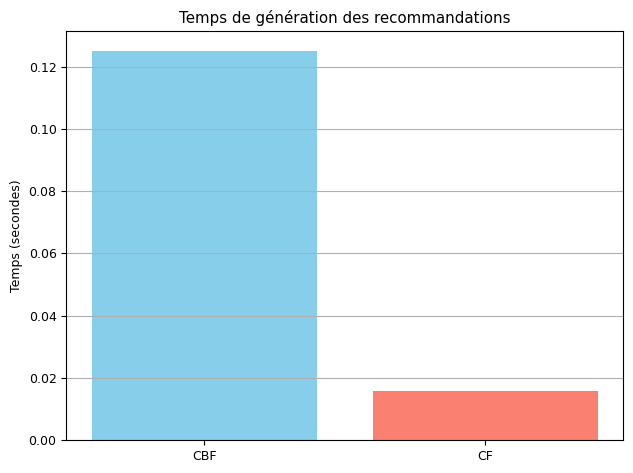

In [70]:
times = {
    "CBF": elapsed_cbf,
    "CF": elapsed_cf
}
plt.bar(times.keys(), times.values(), color=["skyblue", "salmon"])
plt.ylabel("Temps (secondes)")
plt.title("Temps de g√©n√©ration des recommandations")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


Le mod√®le CF est plus rapide car il exploite directement une factorisation pr√©-entra√Æn√©e, tandis que le CBF doit recalculer les similarit√©s √† chaque requ√™te
# 1.6.2 - Taux d'overlap (articles recommand√©s √† la fois en CBF et CF)

In [31]:
overlap = set(reco_article_ids).intersection(set(reco_cf_ids))
overlap_ratio = len(overlap) / top_n

In [32]:
print(f"Articles en commun (overlap) : {overlap}")
print(f"Taux d‚Äôoverlap CBF vs CF : {overlap_ratio:.2%}")

Articles en commun (overlap) : set()
Taux d‚Äôoverlap CBF vs CF : 0.00%


- On observe ici un taux d‚Äôoverlap nul entre CBF et CF. 
    - Cela montre que les deux moteurs exploitent des logiques diff√©rentes et potentiellement compl√©mentaires.
    - Le CBF est focalis√© sur la similarit√© de contenu, tandis que le CF se base sur les comportements d‚Äôautres utilisateurs. 
    - Cela ouvre la voie √† une strat√©gie hybride permettant de combiner pertinence et diversit√©. ¬ª
# 1.6.3 - Distribution par cat√©gorie des recommandations

In [33]:
cat_cbf = df_recommendations["category_id"].value_counts().sort_index()
cat_cf  = df_reco_cf["category_id"].value_counts().sort_index()

In [34]:
comparison_df = pd.DataFrame({
    "CBF" : cat_cbf,
    "CF"  : cat_cf
}).fillna(0).astype(int)

In [35]:
print("Distribution des cat√©gories dans les recommandations :")
display(comparison_df)

Distribution des cat√©gories dans les recommandations :


CBF  CF
category_id         
26             0   1
228            0   1
327            5   0
375            0   2
428            0   1

# 1.6.4 - Visualisation

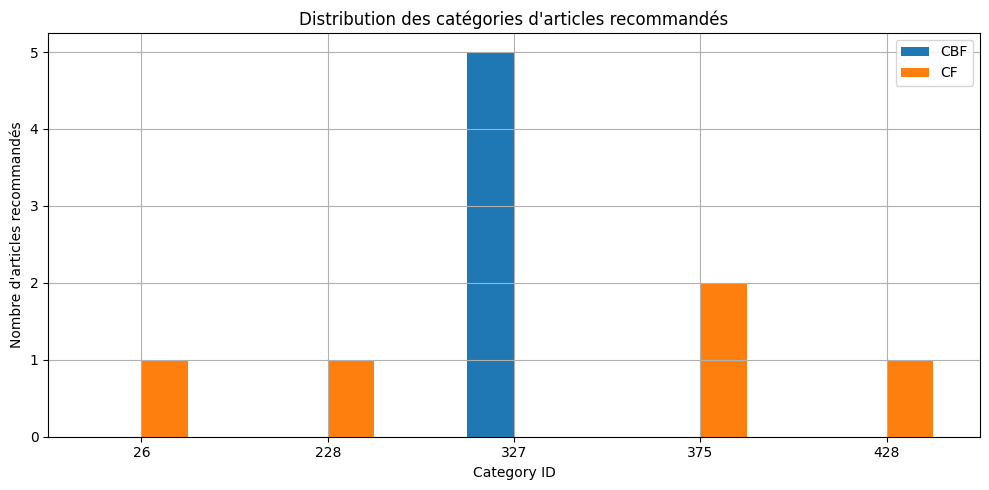

In [36]:
comparison_df.plot(kind = "bar", figsize = (10, 5))
plt.title("Distribution des cat√©gories d'articles recommand√©s")
plt.xlabel("Category ID")
plt.ylabel("Nombre d'articles recommand√©s")
plt.xticks(rotation = 0)
plt.grid(True)
plt.tight_layout()
plt.show()

Le CBF renforce les pr√©f√©rences existantes, tandis que le CF √©largit le spectre des contenus en explorant d'autres cat√©gories. Cette compl√©mentarit√© justifie l‚Äôusage d‚Äôun mod√®le hybride
## 1.7 - Recommandations hybrides CBF + CF

| Ce que c‚Äôest                                                                                     | Ce que √ßa prouve                                                              |
|--------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------|
| Combine les deux approches avec un poids `alpha` ajustable                                       | Capacit√© √† √©quilibrer contenu et communaut√©                                  |
| Permet une personnalisation plus robuste et plus vari√©e                                          | Montre que l'on ma√Ætrises l‚Äôassemblage de techniques ML                    |
| `alpha = 0.0` ‚Üí CF pur ; `alpha = 1.0` ‚Üí CBF pur ; entre deux ‚Üí fusion intelligente              | Flexibilit√© du syst√®me selon les profils utilisateurs      

In [37]:
reco_hybrid_ids = get_hybrid_recommendations(user_id = user_id_test,
                                             df = df,
                                             embeddings = embeddings,
                                             article_id_to_index = article_id_to_index,
                                             model_cf = model_cf,
                                             top_n = 5,
                                             alpha = 0.5)  # 0.5 = mix √©quilibr√©

In [38]:
df_reco_hybrid = df_articles[df_articles["article_id"].isin(reco_hybrid_ids)]
df_reco_hybrid = df_reco_hybrid.sort_values(by = ["category_id", "created_at_ts"])

In [39]:
print("Aper√ßu des articles recommand√©s (Hybride CBF + CF) :")
display(df_reco_hybrid[["article_id", "category_id", "publisher_id", "words_count", "created_at_ts"]])

Aper√ßu des articles recommand√©s (Hybride CBF + CF) :


article_id  category_id  publisher_id  words_count  created_at_ts
58664        58664          118             0          247  1507232155000
202676      202676          327             0          197  1507154338000
202388      202388          327             0          305  1507723340000
203454      203454          327             0          197  1508143318000
205845      205845          331             0          256  1508084126000

### 1.7.1 - Visualisation de la r√©partition des sources

In [40]:
# R√©cup√®ration de tous les article_id recommand√©s pour les 3 m√©thodes
set_cbf     = set(reco_article_ids)
set_cf      = set(reco_cf_ids)
set_hybrid  = set(reco_hybrid_ids)

In [41]:
# Cat√©gorisation des recommandations hybrides
hybrid_only     = set_hybrid - set_cbf - set_cf
hybrid_from_cbf = set_hybrid & set_cbf - set_cf
hybrid_from_cf  = set_hybrid & set_cf - set_cbf
hybrid_overlap  = set_hybrid & set_cbf & set_cf

In [42]:
labels = ["Uniquement CBF", "Uniquement CF", "Communs CBF+CF", "Nouveaux (Hybride)"]
sizes = [len(hybrid_from_cbf), len(hybrid_from_cf), len(hybrid_overlap), len(hybrid_only)]

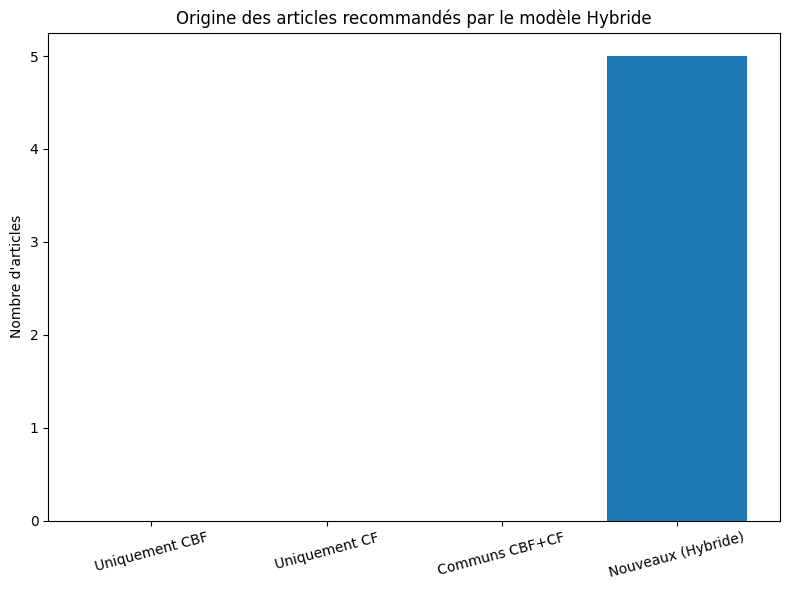

In [43]:
plt.figure(figsize = (8, 6))
plt.bar(labels, sizes)
plt.title("Origine des articles recommand√©s par le mod√®le Hybride")
plt.ylabel("Nombre d'articles")
plt.xticks(rotation = 15)
plt.tight_layout()
plt.show()

- Le mod√®le hybride ne reprend aucun article des recommandations CBF ou CF. Il combine les signaux pour faire √©merger de nouveaux articles, non pr√©sents dans les tops initiaux, offrant ainsi une personnalisation plus subtile.

Le mod√®le hybride propose ici 5 articles totalement in√©dits, d√©montrant sa capacit√© √† faire √©merger des recommandations alternatives √† celles des moteurs CBF ou CF seuls

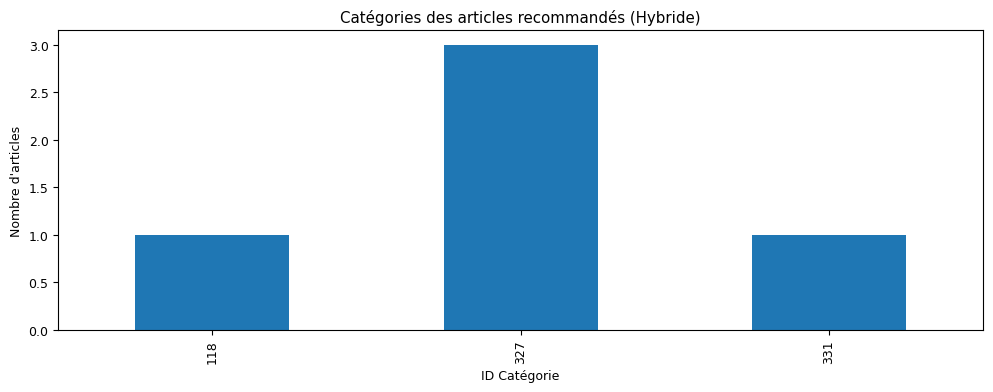

In [ ]:
df_reco_hybrid["category_id"].value_counts().sort_index().plot(kind="bar", figsize=(10, 4))
plt.title("Cat√©gories des articles recommand√©s (Hybride)")
plt.xlabel("ID Cat√©gorie")
plt.ylabel("Nombre d'articles")
plt.tight_layout()
plt.show()

- Le mod√®le hybride conserve une pr√©f√©rence de fond du profil utilisateur (cat. 327), tout en introduisant de nouvelles cat√©gories, montrant un compromis int√©ressant entre fid√©lit√© et exploration.

Le mod√®le hybride combine renforcement des pr√©f√©rences et ouverture √† de nouvelles th√©matiques.
## Heatmap des taux d'overlap entre CBF, CF et Hybride
Cette visualisation permet d‚Äôobserver les pourcentages d‚Äôarticles communs dans les top recommandations g√©n√©r√©es par chaque m√©thode.

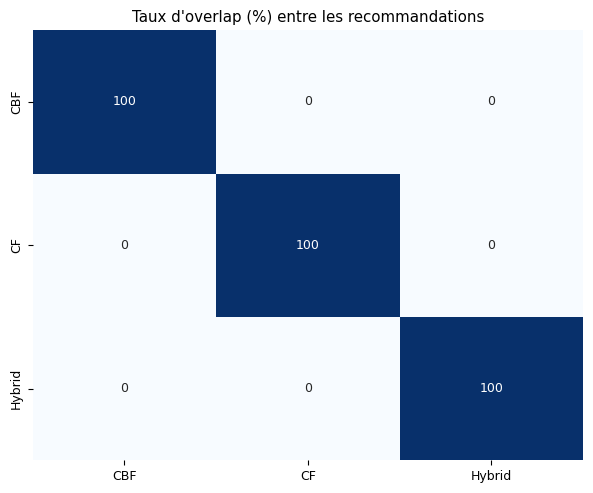

In [69]:
import seaborn as sns

sets = {
    "CBF": set(reco_article_ids),
    "CF": set(reco_cf_ids),
    "Hybrid": set(reco_hybrid_ids)
}

overlap_matrix = pd.DataFrame(index=sets.keys(), columns=sets.keys())

for a in sets:
    for b in sets:
        if a == b:
            overlap_matrix.loc[a, b] = 100
        else:
            overlap_matrix.loc[a, b] = 100 * len(sets[a] & sets[b]) / top_n

overlap_matrix = overlap_matrix.astype(float)

plt.figure(figsize=(6, 5))
sns.heatmap(overlap_matrix, annot=True, cmap="Blues", fmt=".0f", cbar=False)
plt.title("Taux d'overlap (%) entre les recommandations")
plt.tight_layout()
plt.show()


- Les trois mod√®les recommandent ici des articles totalement diff√©rents, d√©montrant leur compl√©mentarit√©. 
    - Cette ind√©pendance justifie l‚Äôint√©r√™t d‚Äôun mod√®le hybride ou multi-strat√©gies.

Aucun article n‚Äôest recommand√© par plus d‚Äôun mod√®le, ce qui confirme la compl√©mentarit√© des approches CBF, CF et Hybride.
### 1.7.2 - Impact du param√®tre alpha
- alpha est un poids de pond√©ration qui contr√¥le la balance entre les deux mod√®les dans la recommandation hybride.
    - Il varie entre 0.0 et 1.0 : 
        - `score_hybride = alpha * score_CBF + (1 - alpha) * score_CF`

### Interpr√©tation par valeur
| alpha | Pond√©ration r√©elle           | Interpr√©tation                                               |
|-------|------------------------------|--------------------------------------------------------------|
| 0.0   | 0 % CBF + 100 % CF           | L‚Äôhybride est identique au CF                                |
| 0.2   | 20 % CBF + 80 % CF           | L‚Äôhybride penche fortement c√¥t√© collaboratif                 |
| 0.5   | 50 % CBF + 50 % CF           | Pond√©ration √©quilibr√©e : CBF et CF ont le m√™me poids         |
| 0.8   | 80 % CBF + 20 % CF           | L‚Äôhybride favorise le contenu tout en gardant un peu de CF   |
| 1.0   | 100 % CBF + 0 % CF           | L‚Äôhybride est identique au CBF       

In [44]:
alphas = [round(a, 2) for a in np.linspace(0, 1, 11)]
overlaps_cbf = []
overlaps_cf = []

In [45]:
for a in alphas:
    hybrid_ids = get_hybrid_recommendations(user_id = user_id_test,
                                            df = df,
                                            embeddings = embeddings,
                                            article_id_to_index = article_id_to_index,
                                            model_cf = model_cf,
                                            top_n = 5,
                                            alpha = a)
    set_hybrid = set(hybrid_ids)
    overlaps_cbf.append(len(set_cbf & set_hybrid) / 5 * 100)
    overlaps_cf.append(len(set_cf & set_hybrid) / 5 * 100)

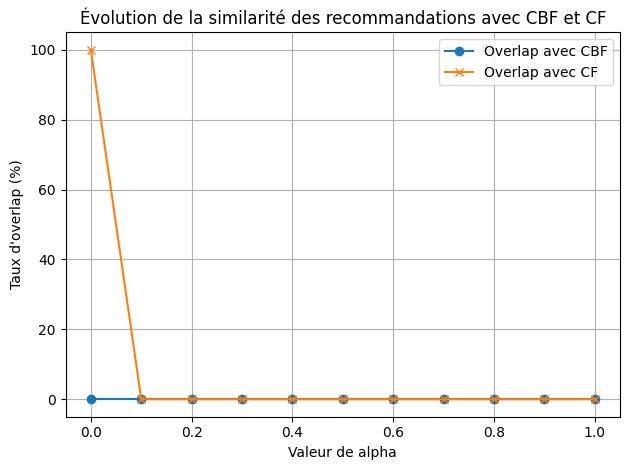

In [46]:
plt.plot(alphas, overlaps_cbf, label = "Overlap avec CBF", marker = "o")
plt.plot(alphas, overlaps_cf, label = "Overlap avec CF", marker = "x")
plt.xlabel("Valeur de alpha")
plt.ylabel("Taux d'overlap (%)")
plt.title("√âvolution de la similarit√© des recommandations avec CBF et CF")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Le mod√®le hybride, d√®s qu‚Äôil mixe les deux sources (alpha ‚â† 0 ou 1), g√©n√®re des recommandations totalement nouvelles, diff√©rentes de celles du CBF ou du CF. Cela d√©montre une vraie capacit√© d‚Äôexploration crois√©e.

D√®s qu‚Äôon m√©lange CBF et CF (alpha ‚â† 0 ou 1), le mod√®le hybride produit des recommandations in√©dites, confirmant son effet combinatoire.
## 1.8 ‚Äì Exploration interactive du param√®tre alpha

In [47]:
# Slider alpha de 0.0 √† 1.0 avec pas de 0.01
alpha_slider = widgets.FloatSlider(
    value = 0.5,
    min = 0.0,
    max = 1.0,
    step = 0.01,
    description = 'alpha',
    readout_format = '.2f',
    style = {'description_width': 'initial'},
    layout = widgets.Layout(width = '50%')
)

In [48]:
# Zone de sortie
output = widgets.Output()

In [49]:
# Lancement du callback lors du d√©placement du slider
alpha_slider.observe(
    lambda change: update_recommendations(change,
                                          user_id = user_id_test,
                                          df = df,
                                          embeddings = embeddings,
                                          article_id_to_index = article_id_to_index,
                                          model_cf = model_cf,
                                          df_articles = df_articles,
                                          output_widget = output,
                                          top_n = 5,
                                          get_hybrid_recommendations_func = get_hybrid_recommendations),
    names = "value"
)


In [50]:
display(alpha_slider, output)

FloatSlider(value=0.5, description='alpha', layout=Layout(width='50%'), max=1.0, step=0.01, style=SliderStyle(‚Ä¶

Output()

In [51]:
# Affichage initial
update_recommendations({"new": alpha_slider.value},
                       user_id = user_id_test,
                       df = df,
                       embeddings = embeddings,
                       article_id_to_index = article_id_to_index,
                       model_cf = model_cf,
                       df_articles = df_articles,
                       output_widget = output,
                       top_n = 5,
                       get_hybrid_recommendations_func = get_hybrid_recommendations)

## 1.9 - Quand utiliser....
### 1.9.1 - Content-Based Filtering (CBF)
| Crit√®re                                         | Choix recommand√© : CBF     |
|-------------------------------------------------|-----------------------------|
| Nouveaux utilisateurs                           | Oui (cold start user)       |
| Nouveaux articles                               | Oui (car CF ne les conna√Æt pas encore) |
| Faible historique utilisateur                   | Oui (utilise juste l‚Äôhistorique personnel) |
| Forte diversit√© d‚Äôarticles                      | Oui (bas√© sur le contenu, ex : embeddings) |
| Explicabilit√© requise                           | Oui (recommandations compr√©hensibles) |
| Objectif                                        | Renforcer les pr√©f√©rences connues, pas explorer |
### 1.9.2 - Collaborative Filtering (CF)
| Crit√®re                                         | Choix recommand√© : CF      |
|-------------------------------------------------|-----------------------------|
| Utilisateurs actifs avec beaucoup d‚Äôinteractions | Oui                         |
| Beaucoup de donn√©es de clics/historiques        | Oui                         |
| Objectif                                        | D√©couverte via les comportements des autres |
| Syst√®me communautaire ou plateforme sociale     | Oui (effet de r√©seau)       |
| Contenus peu structur√©s                         | Oui (CF reste performant)   |
| Probl√®me sur articles r√©cents ou utilisateurs r√©cents | Oui (limitation cold start) |
### 1.9.3 - M√©thode hybride (CBF + CF)
| Crit√®re                                         | Choix recommand√© : Hybride |
|-------------------------------------------------|-----------------------------|
| Besoin de robustesse                            | Oui                         |
| Besoin de personnalisation fine                 | Oui (param√®tre alpha)       |
| Objectif                                        | √âquilibre entre contenu et comportement |
| Syst√®me en production r√©el                      | Oui                         |
| Mise en valeur technique                        | Oui                         |
### 1.9.4 - Recommandation pratique
| Situation dans le projet P10                        | M√©thode sugg√©r√©e              |
|-----------------------------------------------------|-------------------------------|
| Phase test rapide avec utilisateurs fictifs         | CBF                           |
| Mise en valeur d‚Äôun algo en soutenance              | Ajouter CF puis Hybride       |
| Production future                                    | Hybride avec alpha dynamique  |


## 1.10 - Arbre de d√©cision visuel

In [72]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [73]:
# Param√®tres d'affichage
rcParams.update({"font.size": 10})

In [74]:
# Cr√©ation du graphe de d√©cision
G = nx.DiGraph()

In [75]:
# Ajout des noeuds et des transitions
G.add_edges_from([
    ("Donn√©es disponibles ?", "Oui - Donn√©es utilisateurs"),
    ("Donn√©es disponibles ?", "Non ‚Üí Utiliser CBF"),

    ("Oui - Donn√©es utilisateurs", "Beaucoup d'interactions ?"),

    ("Beaucoup d'interactions ?", "Oui ‚Üí Utiliser CF"),
    ("Beaucoup d'interactions ?", "Pas trop ‚Üí Hybride"),

    ("Oui ‚Üí Utiliser CF", "Mise en production ?"),
    ("Pas trop ‚Üí Hybride", "Mise en production ?"),
    ("Non ‚Üí Utiliser CBF", "Mise en production ?"),

    ("Mise en production ?", "Oui ‚Üí Hybride"),
    ("Mise en production ?", "Non ‚Üí Rester sur CF ou CBF")
])

In [76]:
# Positionnement en arbre (layout vertical)
pos = {
    "Donn√©es disponibles ?"        : (0, 5),
    "Oui - Donn√©es utilisateurs"   : (-2, 4),
    "Non ‚Üí Utiliser CBF"           : (2, 4),
    "Beaucoup d'interactions ?"    : (-2, 3),
    "Oui ‚Üí Utiliser CF"            : (-3, 2),
    "Pas trop ‚Üí Hybride"           : (-1, 2),
    "Mise en production ?"         : (-2, 1),
    "Oui ‚Üí Hybride"                : (-3, 0),
    "Non ‚Üí Rester sur CF ou CBF"   : (-1, 0)
}

C:\Users\motar\AppData\Local\Temp\ipykernel_24908\2351566467.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


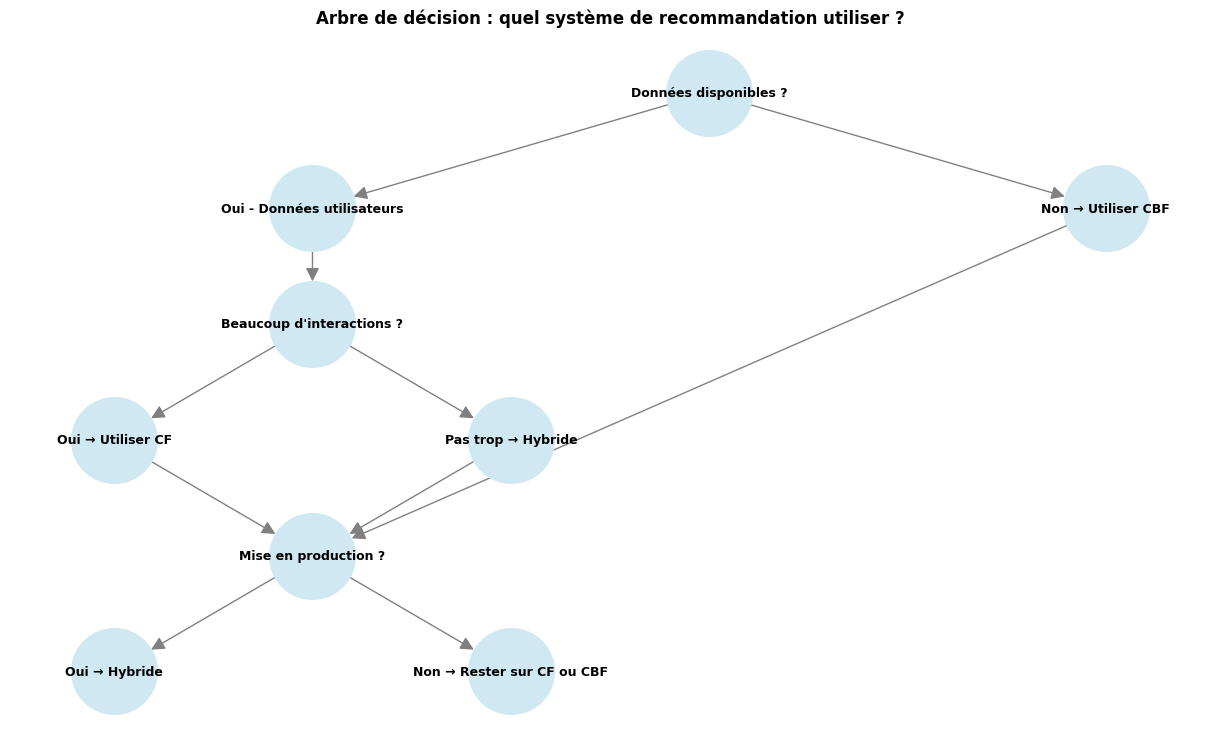

In [79]:
# Cr√©ation du plot
plt.figure(figsize=(12, 7))
nx.draw(
    G, pos,
    with_labels=True,
    node_size=3800,
    node_color="#d0e8f2",
    font_weight="bold",
    font_size=9,
    edge_color="gray",
    arrows=True,
    arrowsize=20
)

plt.title("Arbre de d√©cision : quel syst√®me de recommandation utiliser ?", fontsize=12, weight="bold")
plt.tight_layout()
plt.show()

In [57]:
user_id_test = df["user_id"].sample(1).iloc[0]  

reco_ids = get_recommendations(
    user_id = user_id_test,
    df = df,
    model_cf = model_cf,
    embeddings = embeddings,
    article_id_to_index = article_id_to_index,
    mode = "auto",               # ou "cbf", "cf", "hybrid"
    alpha = 0.6,                 # pour hybrid
    user_clicks_threshold = 5,   # seuil de clics √† partir duquel on bascule
    top_n = 10                   # nombre d‚Äôarticles recommand√©s
)

In [58]:
# Affichage des articles recommand√©s (si dispo dans df_articles)
df_articles[df_articles["article_id"].isin(reco_ids)][
    ["article_id", "category_id", "publisher_id", "words_count", "created_at_ts"]
]

article_id  category_id  publisher_id  words_count  created_at_ts
279886      279886          412             0          166  1432132522000
292685      292685          421             0          241  1504786402000
336251      336251          437             0          178  1504502064000
336991      336991          437             0          174  1501920413000
337192      337192          437             0          158  1507699263000
337205      337205          437             0          220  1515730187000
337505      337505          437             0          203  1510982280000
337799      337799          437             0          193  1516084468000
338277      338277          437             0          187  1505798289000
345753      345753          440             0          197  1519219381000

df = historique clics (clicks_sample ou fusion compl√®te)

df_articles = m√©tadonn√©es articles (articles_metadata.csv)

embeddings = embeddings r√©duits (format .npz ou .pickle)

article_id_to_index = dictionnaire pour retrouver les indices des embeddings

model_cf = mod√®le CF entra√Æn√© (SVD par exemple)

In [59]:
df_articles = pd.read_parquet("../outputs/df_articles.parquet")
print(type(df_articles["embedding"].iloc[0]))  # doit afficher <class 'numpy.ndarray'>

<class 'numpy.ndarray'>


# 2 - Tests
## 2.1 - Test de load_df
Ce bloc v√©rifie :

Que la connexion Azure fonctionne bien (AZURE_CONN_STR).

Que le fichier df_light.parquet est bien pr√©sent dans Azure Blob.

Que le contenu est correctement charg√© dans un DataFrame.

Que le r√©sultat est bien exploitable (affichage .shape, .head()).

In [60]:
# Test des recommandations en mode local
print("=== Test recommandations mode LOCAL ===")
try:
    recommended_ids = get_recommendations_from_user(user_id=8, source="local")
    print(f"Articles recommand√©s : {recommended_ids}")
    print(f"Nombre de recommandations : {len(recommended_ids)}")
except Exception as e:
    print(f"Erreur mode local : {e}")

print("\n=== Test recommandations mode AZURE ===")
try:
    recommended_ids = get_recommendations_from_user(user_id=8, source="azure")
    print(f"Articles recommand√©s : {recommended_ids}")
    print(f"Nombre de recommandations : {len(recommended_ids)}")
except Exception as e:
    print(f"Erreur mode azure : {e}")

=== Test recommandations mode LOCAL ===
Articles recommand√©s : [284178, 285741, 280868, 282755, 284184]
Nombre de recommandations : 5

=== Test recommandations mode AZURE ===
Articles recommand√©s : [284178, 284846, 284845, 284177, 286077]
Nombre de recommandations : 5


In [61]:
try:
    df_from_blob = load_df(source="azure", filename="df_light.parquet")
    print(f"Chargement Azure r√©ussi : {df_from_blob.shape}")
    df_from_blob.head()
except Exception as e:
    print(f"Erreur Azure : {e}")
    print("Utilisation du fichier local...")
    df_from_blob = load_df(source="local", filename="df_light.parquet")
    print(f"Chargement local r√©ussi : {df_from_blob.shape}")
print(df_from_blob.shape)
df_from_blob.head()

Chargement Azure r√©ussi : (10342, 19)
(10342, 19)


user_id        session_id  session_start  session_size  article_id  \
0        8  1506825573366745  1506825573000             3      332114   
1        8  1506825573366745  1506825573000             3      284847   
2        8  1506825573366745  1506825573000             3      114161   
3       96  1506826575357833  1506826575000             2      145166   
4       96  1506826575357833  1506826575000             2      284847   

          click_timestamp  click_environment  click_deviceGroup  click_os  \
0 2017-10-01 03:03:19.683                  4                  3        20   
1 2017-10-01 03:10:38.642                  4                  3        20   
2 2017-10-01 03:11:08.642                  4                  3        20   
3 2017-10-01 03:04:33.011                  4                  1        17   
4 2017-10-01 03:05:03.011                  4                  1        17   

   click_country  click_region  click_referrer_type  category_id  \
0              1            12                    1          436   
1              1            12                    1          412   
2              1            12                    1          237   
3              1            25                    2          269   
4              1            25                    2          412   

   created_at_ts  publisher_id  words_count  hour     day    month  
0  1506791182000             0          265     3  Sunday  2017-10  
1  1506802073000             0          266     3  Sunday  2017-10  
2  1506799438000             0          154     3  Sunday  2017-10  
3  1506785272000             0          180     3  Sunday  2017-10  
4  1506802073000             0          266     3  Sunday  2017-10

In [62]:
from wrappers import get_recommendations_from_user
get_recommendations_from_user(user_id=8, source="local")

[284178, 285741, 280868, 282755, 284184]

## 2.2 - S√©quence de tests fonctionnels ‚Äì Lecture Azure Blob
### 2.2.1 - Connexion √† Azure & lecture de df_light.parquet
V√©rifie :

Connexion valide

Pr√©sence du blob df_light.parquet

Donn√©es exploitables (affichage des colonnes)

In [63]:
from loaders import load_df

df_blob = load_df(source="azure")
print(df_blob.shape)
df_blob.head()

(10342, 19)


user_id        session_id  session_start  session_size  article_id  \
0        8  1506825573366745  1506825573000             3      332114   
1        8  1506825573366745  1506825573000             3      284847   
2        8  1506825573366745  1506825573000             3      114161   
3       96  1506826575357833  1506826575000             2      145166   
4       96  1506826575357833  1506826575000             2      284847   

          click_timestamp  click_environment  click_deviceGroup  click_os  \
0 2017-10-01 03:03:19.683                  4                  3        20   
1 2017-10-01 03:10:38.642                  4                  3        20   
2 2017-10-01 03:11:08.642                  4                  3        20   
3 2017-10-01 03:04:33.011                  4                  1        17   
4 2017-10-01 03:05:03.011                  4                  1        17   

   click_country  click_region  click_referrer_type  category_id  \
0              1            12                    1          436   
1              1            12                    1          412   
2              1            12                    1          237   
3              1            25                    2          269   
4              1            25                    2          412   

   created_at_ts  publisher_id  words_count  hour     day    month  
0  1506791182000             0          265     3  Sunday  2017-10  
1  1506802073000             0          266     3  Sunday  2017-10  
2  1506799438000             0          154     3  Sunday  2017-10  
3  1506785272000             0          180     3  Sunday  2017-10  
4  1506802073000             0          266     3  Sunday  2017-10

### 2.2.2 - Lecture des embeddings compress√©s .np
V√©rifie :

Connexion valide

Pr√©sence de articles_embeddings_compressed.npz

Bonne cl√© "embeddings" dans le fichier

In [64]:
from dotenv import load_dotenv
load_dotenv()

False

In [65]:
from loaders import load_cf_model

# Test avec les bons param√®tres pour Azure
print("=== Test chargement mod√®le CF AZURE ===")
try:
    model_cf = load_cf_model(source="azure", 
                            filename="model_cf_light.pkl", 
                            container_name="artefacts-fresh")
    print(f"Mod√®le Azure charg√© avec succ√®s : {type(model_cf)}")
except Exception as e:
    print(f"Erreur Azure : {e}")
    print("Tentative en local...")
    try:
        model_cf = load_cf_model(source="local", filename="model_cf.pkl")
        print(f"Mod√®le local charg√© avec succ√®s : {type(model_cf)}")
    except Exception as e2:
        print(f"Erreur locale : {e2}")

print("\n=== Test chargement mod√®le CF LOCAL ===")
try:
    model_cf_local = load_cf_model(source="local", filename="model_cf.pkl")
    print(f"Mod√®le local charg√© avec succ√®s : {type(model_cf_local)}")
except Exception as e:
    print(f"Erreur locale : {e}")

=== Test chargement mod√®le CF AZURE ===
Mod√®le Azure charg√© avec succ√®s : <class 'surprise.prediction_algorithms.matrix_factorization.SVD'>

=== Test chargement mod√®le CF LOCAL ===
Mod√®le local charg√© avec succ√®s : <class 'surprise.prediction_algorithms.matrix_factorization.SVD'>


### 2.2.3 - Appel final de la fonction get_recommendations_from_user()
 V√©rifie :

L‚Äôensemble du pipeline depuis Azure

L‚Äôappel fonctionnel sans erreur

Une recommandation coh√©rente (liste d‚ÄôIDs)

In [66]:
import json
import random
from wrappers import get_recommendations_from_user

print("=== Test avec user_id al√©atoire valide ===")

# Chargement des user_ids valides depuis le fichier g√©n√©r√© par le notebook 03
try:
    with open("outputs/user_ids_valid.json", "r") as f:
        valid_user_ids = json.load(f)
    
    print(f"Nombre d'utilisateurs valides disponibles : {len(valid_user_ids)}")
    
    # S√©lection al√©atoire d'un user_id valide
    random_user_id = random.choice(valid_user_ids)
    print(f"User_id s√©lectionn√© al√©atoirement : {random_user_id}")
    
    # Test des recommandations
    recs = get_recommendations_from_user(
        user_id=random_user_id,
        mode="auto",
        source="azure"
    )
    print(f"Recommandations pour user_id {random_user_id} : {recs}")
    print(f"Nombre de recommandations : {len(recs)}")
    
except FileNotFoundError:
    print("Fichier user_ids_valid.json non trouv√©. Utilisation d'un user_id de test connu.")
    # Fallback sur un user_id que tu sais fonctionner
    test_user_id = 8
    recs = get_recommendations_from_user(
        user_id=test_user_id,
        mode="auto",
        source="azure"
    )
    print(f"Recommandations pour user_id {test_user_id} (test) : {recs}")

except Exception as e:
    print(f"Erreur : {e}")

=== Test avec user_id al√©atoire valide ===
Fichier user_ids_valid.json non trouv√©. Utilisation d'un user_id de test connu.
Recommandations pour user_id 8 (test) : [284178, 284846, 284845, 284177, 286077]


# 3 - Arborescence du projet

In [67]:
import os

def afficher_arborescence(racine: str, prefixe: str = "", niveau: int = 0, max_level: int = 3):
    """
    Affiche l‚Äôarborescence du dossier jusqu‚Äô√† une profondeur donn√©e.

    Param√®tres :
    -----------
    racine : str
        Chemin du dossier √† explorer
    prefixe : str
        Pr√©fixe d‚Äôindentation (utile pour la r√©cursivit√©)
    niveau : int
        Niveau actuel de profondeur
    max_level : int
        Profondeur maximale d‚Äôaffichage
    """
    if niveau > max_level:
        return

    try:
        elements = sorted(os.listdir(racine))
    except PermissionError:
        print(f"{prefixe}[Permission Denied] {racine}")
        return

    for element in elements:
        chemin = os.path.join(racine, element)
        if os.path.isdir(chemin):
            print(f"{prefixe}üìÅ {element}/")
            afficher_arborescence(chemin, prefixe + "    ", niveau + 1, max_level)
        else:
            print(f"{prefixe}üìÑ {element}")


In [68]:
racine_projet = "C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P10/2-python"
afficher_arborescence(racine_projet, max_level=2)

üìÑ .env.dev
üìÑ .env.prod
üìÅ .git/
    üìÑ COMMIT_EDITMSG
    üìÑ HEAD
    üìÑ config
    üìÑ description
    üìÅ hooks/
        üìÑ applypatch-msg.sample
        üìÑ commit-msg.sample
        üìÑ fsmonitor-watchman.sample
        üìÑ post-update.sample
        üìÑ pre-applypatch.sample
        üìÑ pre-commit.sample
        üìÑ pre-merge-commit.sample
        üìÑ pre-push.sample
        üìÑ pre-rebase.sample
        üìÑ pre-receive.sample
        üìÑ prepare-commit-msg.sample
        üìÑ push-to-checkout.sample
        üìÑ sendemail-validate.sample
        üìÑ update.sample
    üìÑ index
    üìÅ info/
        üìÑ exclude
    üìÅ logs/
        üìÑ HEAD
        üìÅ refs/
    üìÅ objects/
        üìÅ 00/
        üìÅ 03/
        üìÅ 05/
        üìÅ 08/
        üìÅ 0a/
        üìÅ 11/
        üìÅ 12/
        üìÅ 14/
        üìÅ 15/
        üìÅ 17/
        üìÅ 18/
        üìÅ 1b/
        üìÅ 1f/
        üìÅ 20/
        üìÅ 23/
        üìÅ 25/
  